### Train a model to predict water level in a lake

In [1]:
import argparse
import pandas as pd
import hopsworks
from datetime import date
import json
import requests
import os

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score

import math


parser = argparse.ArgumentParser()
parser.add_argument("--latitude", type=float, default=59.3284)
parser.add_argument("--longitude", type=float, default=18.0664)
parser.add_argument("--sensor-id", type=int, default=20389)
parser.add_argument("--sensor-name", type=str, default="malaren_w")
parser.add_argument("--water-level-fg-version", type=int, default=4)
parser.add_argument("--weather-fg-version", type=int, default=3)
parser.add_argument("--test-ratio", type=float, default=0.2)

args, _ = parser.parse_known_args()

latitude = args.latitude
longitude = args.longitude
sensor_id = args.sensor_id
sensor_name = args.sensor_name
water_level_fg_version = args.water_level_fg_version
weather_fg_version = args.weather_fg_version
test_ratio = args.test_ratio


### Step 1: Login to hopsworks

Environment variable `HOPSWORKS_API_KEY` should be set

In [115]:
project = hopsworks.login(
    host="eu-west.cloud.hopsworks.ai",
    port=443,
    project="ml_project",
    api_key_value="wtoN33kI3N6NEoXN.uGN8iXjW9Cqw6lSFkvNMrDJh8xe9VEXnhhWhbaeiY1DmMHspWCFJrRzYSkzdfk0R"
)
fs = project.get_feature_store()

2026-01-06 13:30:47,501 INFO: Closing external client and cleaning up certificates.
2026-01-06 13:30:47,504 INFO: Connection closed.
2026-01-06 13:30:47,506 INFO: Initializing external client
2026-01-06 13:30:47,507 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-06 13:30:48,916 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/2184


### Step 2: Retrieve feature groups and create a feature view

In [116]:
water_level_fg = fs.get_feature_group(
    name=f"water_level_lagged_{sensor_name}_{sensor_id}",
    version=water_level_fg_version,
)

weather_fg = fs.get_feature_group(
    name=f"weather_features_{sensor_name}_{sensor_id}",
    version=weather_fg_version,
)

In [151]:
water_level_features = [
    "water_level_cm",
    "water_level_cm_t_1",
    "water_level_cm_t_3",
    "water_level_cm_t_7",
    "water_level_cm_t_14",
]

weather_features = [
    # Local
    "precipitation_sum",
    "snowfall_sum",
    "rain_sum",
    "temperature_2m_mean",
    "wind_speed_10m_mean",
    "surface_pressure_mean",

    # Aggregated
    "precip_sum_3d",
    "precip_sum_7d",
    "precip_sum_14d",
    "snow_sum_14d",
    "snow_sum_30d",
    "snow_sum_60d",
]

# Spatial (75 km)
for d in ["n", "s", "e", "w"]:
    weather_features.extend([
        f"precipitation_sum_{d}_75km",
        f"snowfall_sum_{d}_75km",
        f"rain_sum_{d}_75km",
        f"temperature_2m_mean_{d}_75km",
        f"wind_speed_10m_mean_{d}_75km",
        f"surface_pressure_mean_{d}_75km",
    ])

In [152]:
query = (
    water_level_fg
    .select(["date"] + water_level_features)
    .join(
        weather_fg.select(weather_features),
        on=["sensor_id", "date"]
    )
)

In [153]:
@hopsworks.udf(
    return_type=[int] * 12,   # month_1 ... month_12
    mode="pandas"
)
def add_month_one_hot(date: pd.Series) -> pd.DataFrame:
    """
    One-hot encode month from event-time column.
    """
    # Extract month (1–12)
    month = pd.to_datetime(date).dt.month

    # One-hot encode
    dummies = pd.get_dummies(month, prefix="month")

    # Ensure ALL 12 months exist (critical!)
    for m in range(1, 13):
        col = f"month_{m}"
        if col not in dummies:
            dummies[col] = 0

    # Stable column order
    dummies = dummies[[f"month_{m}" for m in range(1, 13)]]

    return dummies.astype("int32")

2026-01-06 14:37:23,196 WARNING: UserWarning: Cannot extract imported dependencies for the UDF from the module in which it is defined. Please make sure to import all dependencies for the UDF inside the function.



In [155]:
fv = fs.get_or_create_feature_view(
    name=f"water_level_training_view_{sensor_name}_{sensor_id}",
    version=2,
    query=query,
    description=(
        "Training feature view for water level prediction. "
        "Combines lagged water level features, weather features, "
        "and on-demand month one-hot encoding."
    ),
    labels=["water_level_cm"],   # prediction target
    transformation_functions=[add_month_one_hot],
)

In [126]:
full_df = query.read()
full_df = full_df.sort_values("date")

n = len(full_df)
print(n)

split_idx = int(n * (1 - test_ratio))
split_date = full_df.iloc[split_idx]["date"]

print(f"Train fraction: {test_ratio}")
print(f"Suggested test_start date: {split_date}")

test_start = split_date
print(test_start)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.53s) from Hopsworks, using Hopsworks Feature Query Service.   
2182
Train fraction: 0.2
Suggested test_start date: 2024-10-25 00:00:00
2024-10-25 00:00:00


In [142]:
# test_start = test_start = "2024-01-01"

X_train, X_test, y_train, y_test = fv.train_test_split(
    test_start=test_start
)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.01s) from Hopsworks, using Hopsworks Feature Query Service.   
2026-01-06 14:26:12,116 INFO: Computing insert statistics
2026-01-06 14:26:12,194 INFO: Computing insert statistics
2026-01-06 14:26:14,408 WARNING: VersionWarning: Incremented version to `4`.

2026-01-06 14:26:14,409 INFO: Provenance cached data - overwriting last accessed/created training dataset from 3 to 4.
X_train: (1745, 53)
X_test: (437, 53)
y_train: (1745, 1)
y_test: (437, 1)


In [143]:
# --- CLEANING ---
# Drop rows where either X or y has NaNs (keep alignment)
train_mask = X_train.notna().all(axis=1) & y_train.notna().all(axis=1)
test_mask = X_test.notna().all(axis=1) & y_test.notna().all(axis=1)

X_train = X_train.loc[train_mask].reset_index(drop=True)
y_train = y_train.loc[train_mask].reset_index(drop=True)

X_test = X_test.loc[test_mask].reset_index(drop=True)
y_test = y_test.loc[test_mask].reset_index(drop=True)

print("\nAfter cleaning:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


After cleaning:
X_train: (1700, 53)
X_test: (437, 53)
y_train: (1700, 1)
y_test: (437, 1)


In [144]:
assert not X_train.isna().any().any()
assert not y_train.isna().any().any()
assert not X_test.isna().any().any()
assert not y_test.isna().any().any()

In [158]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [146]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective='reg:squarederror',
    random_state=42
)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [147]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

2026-01-06 14:26:51,826 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-06 14:26:51,828 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

MSE: 0.768519650086216
2026-01-06 14:26:51,831 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-06 14:26:51,832 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

R squared: 0.971834998503637


In [148]:
df = y_test
df['predicted_water_level_cm'] = y_pred

In [149]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(10)

,water_level_cm,predicted_water_level_cm,date
226,84.0,82.682487,2024-10-25
341,84.0,83.526817,2024-10-26
373,83.0,83.802742,2024-10-27
100,84.0,83.070374,2024-10-28
77,83.0,84.232849,2024-10-29
49,83.0,82.449936,2024-10-30
50,82.0,83.236801,2024-10-31
319,82.0,81.674782,2024-11-01
124,81.0,82.681877,2024-11-02
246,81.0,81.294495,2024-11-03


In [159]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "../artifacts"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

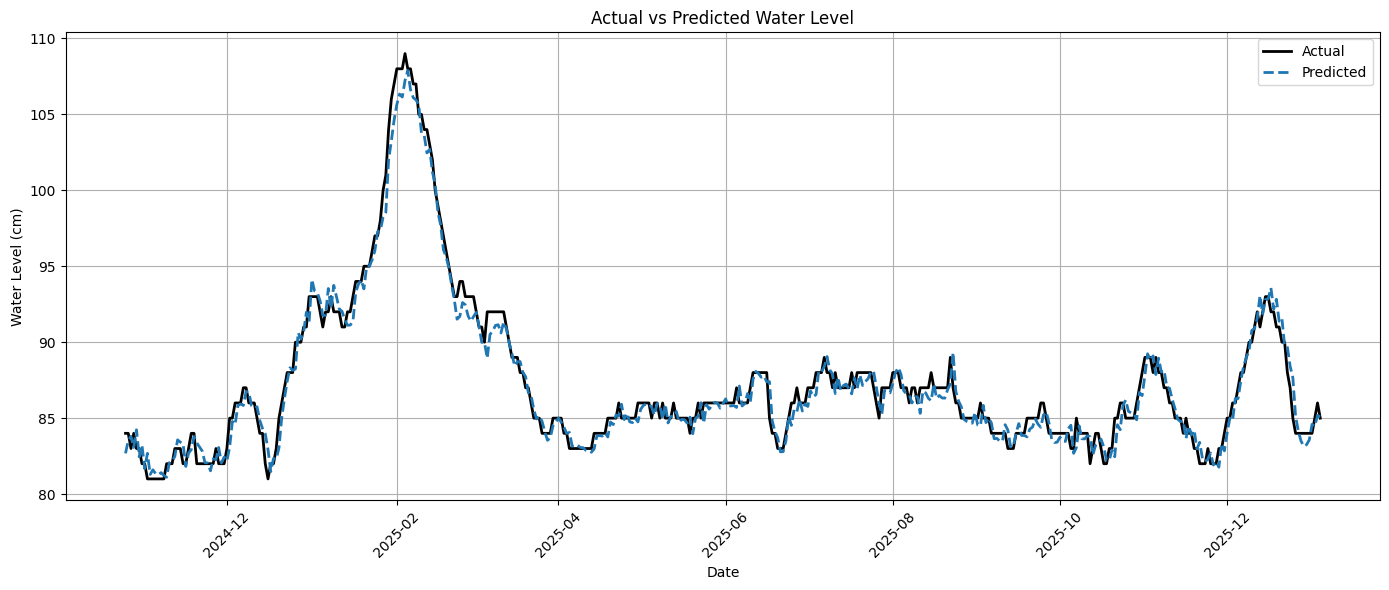

In [163]:
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_actual_vs_predicted(
    df,
    output_dir,
    output_filename,
    date_col="date",
    actual_col="water_level_cm",
    pred_col="predicted_water_level_cm",
    title="Actual vs Predicted Water Level",
):
    """
    Plot actual vs predicted water level over time.
    """

    # Defensive copy and sort
    df_plot = df[[date_col, actual_col, pred_col]].copy()
    df_plot[date_col] = pd.to_datetime(df_plot[date_col], utc=True)
    df_plot = df_plot.sort_values(date_col)

    plt.figure(figsize=(14, 6))

    plt.plot(
        df_plot[date_col],
        df_plot[actual_col],
        label="Actual",
        linewidth=2,
        color="black",
    )

    plt.plot(
        df_plot[date_col],
        df_plot[pred_col],
        label="Predicted",
        linewidth=2,
        linestyle="--",
        color="tab:blue",
    )

    # ✅ ADD ONLY THESE LINES
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 2 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)

    plt.xlabel("Date")
    plt.ylabel("Water Level (cm)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    output_path = os.path.join(output_dir, output_filename)
    plt.savefig(output_path, dpi=150)

    plt.show()


plot_actual_vs_predicted(df, images_dir, f"actual_vs_predicted_{sensor_name}_{sensor_id}.png")